In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,2,33
2,2013-01-01,1,3,15
3,2013-01-01,1,4,10
4,2013-01-01,1,5,11


In [14]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

In [13]:
train.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [15]:
print('Start: ', train['date'].min().date())
print('End: ', train['date'].max().date())

Start:  2013-01-01
End:  2017-12-31


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456500 entries, 0 to 456499
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    456500 non-null  datetime64[ns]
 1   store   456500 non-null  int64         
 2   item    456500 non-null  int64         
 3   sales   456500 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 13.9 MB


In [18]:
train.describe()

,store,item,sales
count,456500.000000,456500.000000,456500.000000
mean,3.000000,25.500000,53.701051
std,1.414215,14.430885,29.106371
min,1.000000,1.000000,1.000000
25%,2.000000,13.000000,31.000000
50%,3.000000,25.500000,49.000000
75%,4.000000,38.000000,71.000000
max,5.000000,50.000000,231.000000


In [19]:
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

train = expand_df(train)
train.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-01,1,2,33,1,1,2013,1
2,2013-01-01,1,3,15,1,1,2013,1
3,2013-01-01,1,4,10,1,1,2013,1
4,2013-01-01,1,5,11,1,1,2013,1


In [20]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [21]:
store_daily_sales.head()

,store,date,sales
0,1,2013-01-01,1316
1,1,2013-01-02,1264
2,1,2013-01-03,1305
3,1,2013-01-04,1452
4,1,2013-01-05,1499


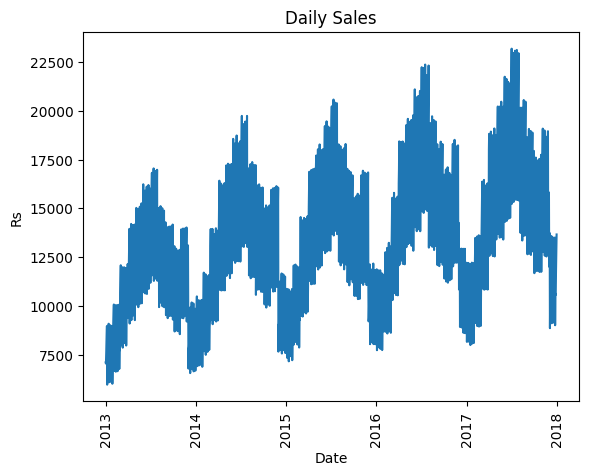

In [22]:
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.ylabel('Rs')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

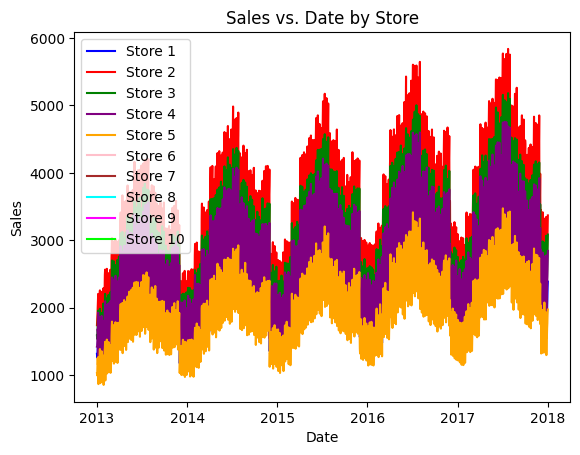

In [23]:
store_colors = {
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'purple',
    5: 'orange'
}

fig, ax = plt.subplots()
for store, color in store_colors.items():
    store_data = store_daily_sales[store_daily_sales['store'] == store]
    ax.plot(store_data['date'], store_data['sales'], label=f'Store {store}', color=color)

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales vs. Date by Store')
ax.legend()

# Show the plot
plt.show()

In [24]:
item_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
day_sales = train.groupby(['day', 'date'], as_index=False)['sales'].sum()
month_sales = train.groupby(['month', 'date'], as_index=False)['sales'].sum()
year_sales = train.groupby(['year', 'date'], as_index=False)['sales'].sum()
day_of_week_sales = train.groupby(['dayofweek', 'date'], as_index=False)['sales'].sum()

In [25]:
item_sales.head()

,item,date,sales
0,1,2013-01-01,65
1,1,2013-01-02,56
2,1,2013-01-03,60
3,1,2013-01-04,71
4,1,2013-01-05,80


Text(0.5, 1.0, 'Sales vs. Date by Item')

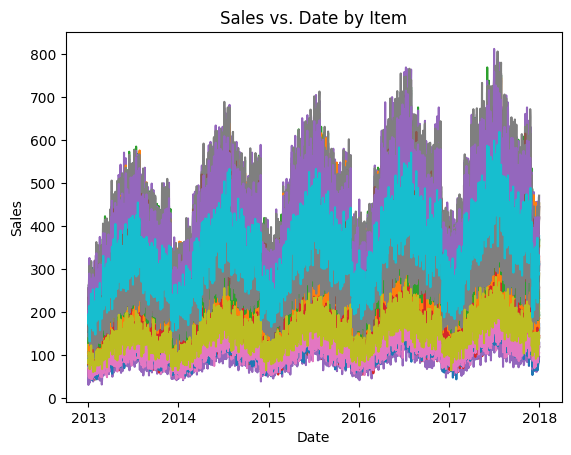

In [26]:
unique_items = item_sales['item'].unique()

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate through unique items and plot sales data for each item
for item in unique_items:
    item_data = item_sales[item_sales['item'] == item]
    ax.plot(item_data['date'], item_data['sales'], label=f'Item {item}')

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales vs. Date by Item')

<Figure size 640x480 with 0 Axes>

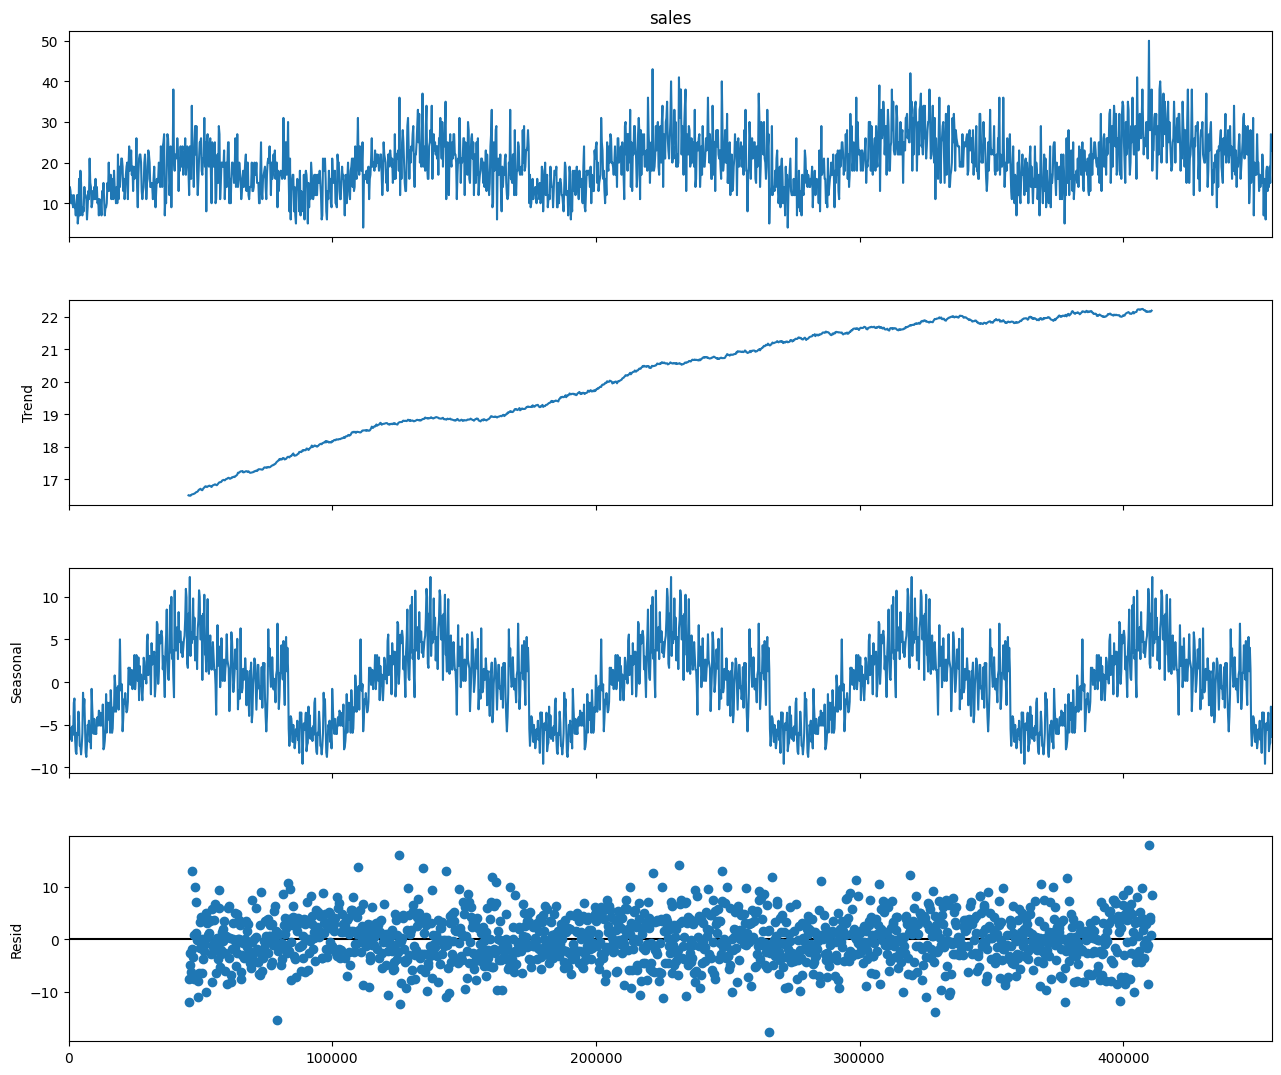

In [27]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = train[train['item']==1]
train_final = train_item1[train_item1['store']==1]

#from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(train_final['sales'], model='additive', period=365) #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

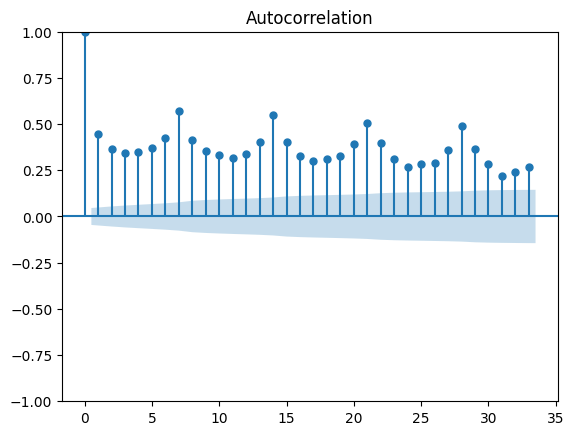

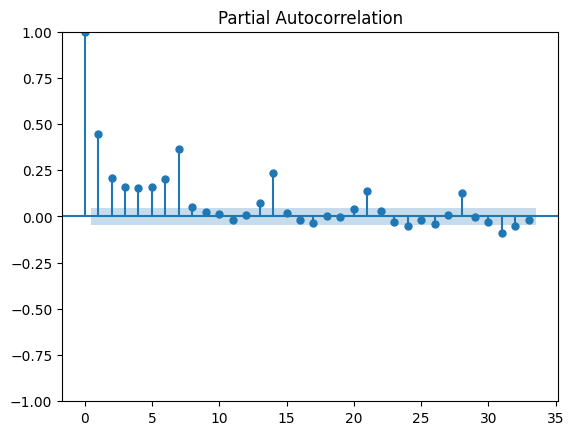

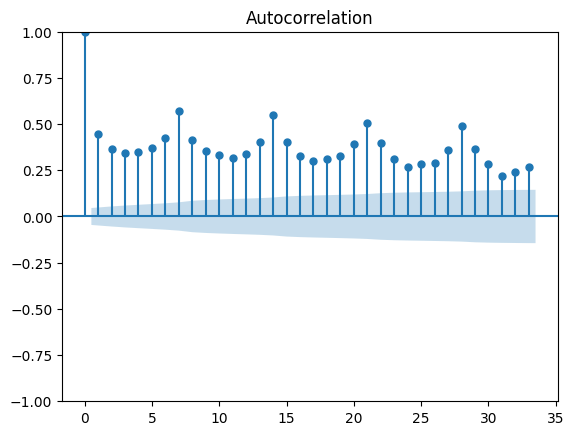

In [28]:
plot_pacf(train_final['sales'])
plot_acf(train_final['sales'])

In [29]:
ad_fuller_result = adfuller(train_final['sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.157670556332822
p-value: 0.022569380626570396


In [30]:
first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())
print()

ad_fuller_result = adfuller(first_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

250    -2.0
500     3.0
750    -1.0
1000   -3.0
1250    2.0
Name: sales, dtype: float64

ADF Statistic: -12.676793886047534
p-value: 1.2109276320433425e-23


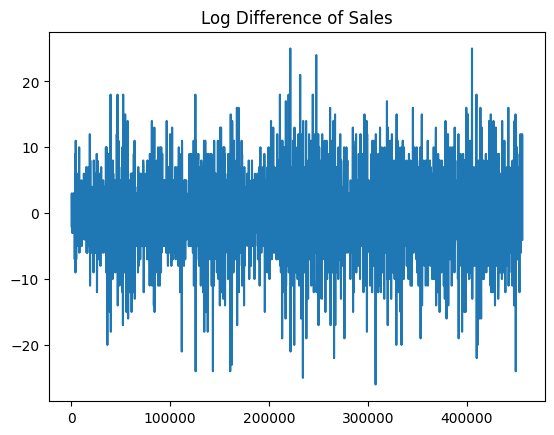

In [31]:
plt.plot(first_diff)
plt.title("Log Difference of Sales")
plt.show()

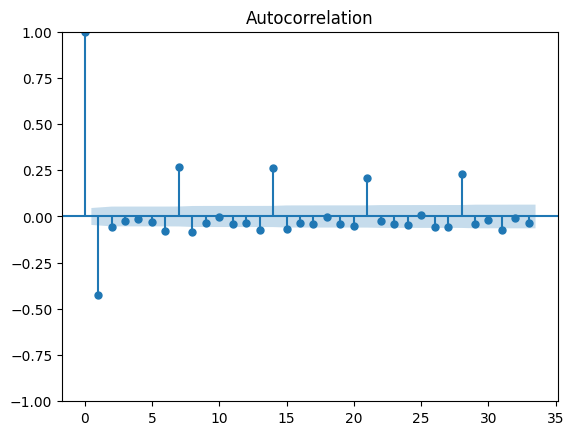

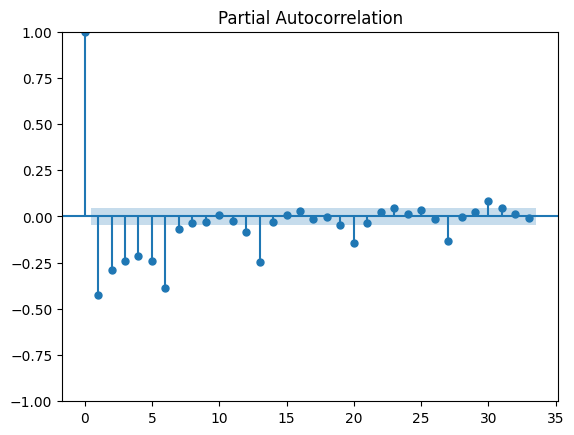

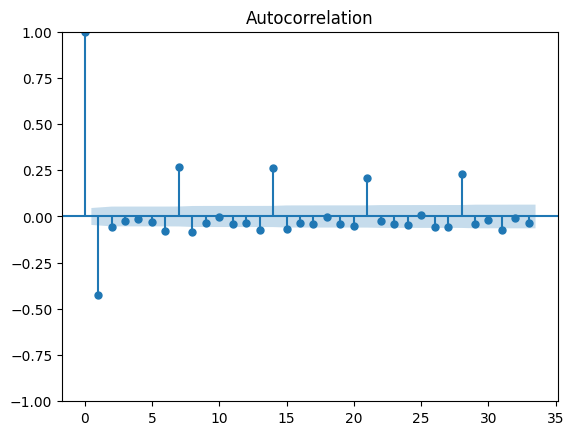

In [32]:
plot_pacf(first_diff)
plot_acf(first_diff)

In [33]:
buf = train[(train.item==1)&(train.store==1)].copy()

In [34]:
buf.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
250,2013-01-02,1,1,11,2,1,2013,2
500,2013-01-03,1,1,14,3,1,2013,3
750,2013-01-04,1,1,13,4,1,2013,4
1000,2013-01-05,1,1,10,5,1,2013,5


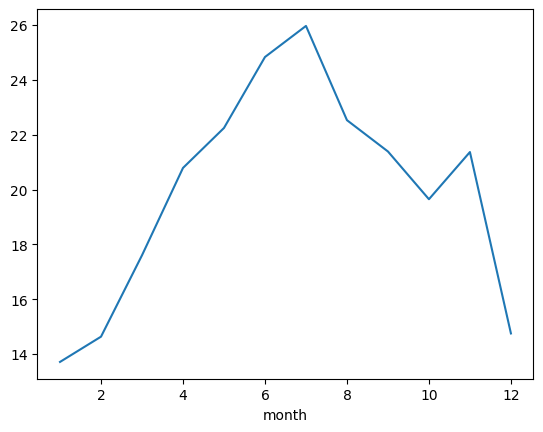

In [36]:
buf.groupby(buf.month).sales.mean().plot()
plt.show()

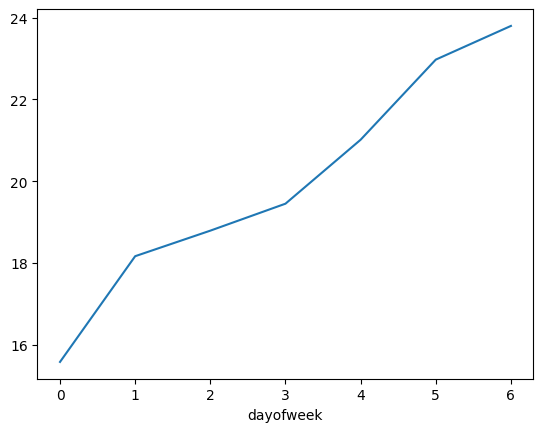

In [37]:
buf.groupby(buf.dayofweek).sales.mean().plot()
plt.show()

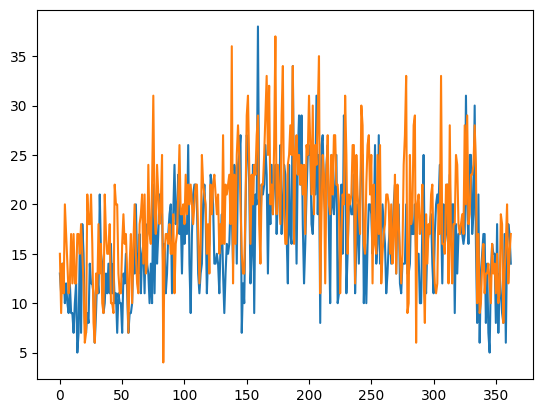

In [38]:
plt.plot(buf[0:363].sales.dropna().values)
plt.plot(buf[364:727].sales.dropna().values)
plt.show()

In [40]:
buf.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
250,2013-01-02,1,1,11,2,1,2013,2
500,2013-01-03,1,1,14,3,1,2013,3
750,2013-01-04,1,1,13,4,1,2013,4
1000,2013-01-05,1,1,10,5,1,2013,5


In [41]:
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]

In [42]:
month_dummies.head()

,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,1,0,0,0,0,0,0,0,0,0,0,0
250,1,0,0,0,0,0,0,0,0,0,0,0
500,1,0,0,0,0,0,0,0,0,0,0,0
750,1,0,0,0,0,0,0,0,0,0,0,0
1000,1,0,0,0,0,0,0,0,0,0,0,0


In [44]:
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)

In [45]:
buf.head()

,date,store,item,sales,day,year,dayofweek,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,2013-01-01,1,1,13,1,2013,1,1,0,0,0,0,0,0,0,0,0,0,0
250,2013-01-02,1,1,11,2,2013,2,1,0,0,0,0,0,0,0,0,0,0,0
500,2013-01-03,1,1,14,3,2013,3,1,0,0,0,0,0,0,0,0,0,0,0
750,2013-01-04,1,1,13,4,2013,4,1,0,0,0,0,0,0,0,0,0,0,0
1000,2013-01-05,1,1,10,5,2013,5,1,0,0,0,0,0,0,0,0,0,0,0


In [46]:
buf.columns

Index(['date', 'store', 'item', 'sales', 'day', 'year', 'dayofweek', 'month-1',
       'month-2', 'month-3', 'month-4', 'month-5', 'month-6', 'month-7',
       'month-8', 'month-9', 'month-10', 'month-11', 'month-12'],
      dtype='object')

In [47]:
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf = pd.concat([buf, week_dummies], axis=1)
#Satday,Sunday
buf['weekend'] = (buf.dayofweek>4).astype(int)
buf = buf.drop(['dayofweek'],axis=1)

In [48]:
buf.head()

,date,store,item,sales,day,year,month-1,month-2,month-3,month-4,...,month-11,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend
0,2013-01-01,1,1,13,1,2013,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
250,2013-01-02,1,1,11,2,2013,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
500,2013-01-03,1,1,14,3,2013,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
750,2013-01-04,1,1,13,4,2013,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1000,2013-01-05,1,1,10,5,2013,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [49]:
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)

In [50]:
buf.index = buf['date']

In [51]:
buf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1826 non-null   datetime64[ns]
 1   store              1826 non-null   int64         
 2   item               1826 non-null   int64         
 3   sales              1826 non-null   int64         
 4   day                1826 non-null   int64         
 5   year               1826 non-null   int64         
 6   month-1            1826 non-null   uint8         
 7   month-2            1826 non-null   uint8         
 8   month-3            1826 non-null   uint8         
 9   month-4            1826 non-null   uint8         
 10  month-5            1826 non-null   uint8         
 11  month-6            1826 non-null   uint8         
 12  month-7            1826 non-null   uint8         
 13  month-8            1826 non-null   uint8     

In [52]:
tr_end = '2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'

tra = buf['sales'][:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

exog_train = buf.drop(['date','store','item','sales'],axis = 1)[:tr_end]
exog_test = buf.drop(['date', 'store','item','sales'],axis = 1)[te_start:te_end]

In [53]:
exog_train.shape

(1734, 24)

In [54]:
tra

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-09-26    18
2017-09-27    27
2017-09-28    23
2017-09-29    28
2017-09-30    30
Name: sales, Length: 1734, dtype: int64

In [55]:
exog_train = exog_train.reindex(tra.index).fillna(0)
exog_test = exog_test.reindex(tes.index).fillna(0)

In [56]:
exog_train = exog_train.astype(int)

In [57]:
best_model = SARIMAX(tra, order=(6,1,7), seasonal_order=(0,0,0,0), exog = exog_train,freq='D',enforce_stationarity=False, enforce_invertibility=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:               SARIMAX(6, 1, 7)   Log Likelihood               -5017.318
Date:                Sat, 09 Mar 2024   AIC                          10110.636
Time:                        11:54:23   BIC                          10317.849
Sample:                    01-01-2013   HQIC                         10187.291
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
day                   0.0123      0.012      1.015      0.310      -0.011       0.036
year                  0.5361      1.315      0.408      0.684      -2.042       3.114
month-1              -6.

In [59]:
exog_test = exog_test.astype(int)  # Convert to float or appropriate numeric type

In [60]:
from sklearn.metrics import mean_squared_error
pred = res.predict(tr_end,te_end,exog = exog_test)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMAX model MSE:22.951619967586442


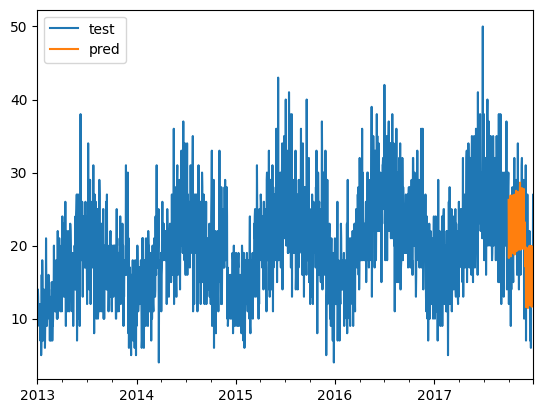

In [61]:
pd.DataFrame({'test':buf['sales'],'pred':pred}).plot();plt.show()

In [62]:
train = pd.read_csv('train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv('test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)
sample = pd.read_csv('sample_submission.csv')

In [63]:
df['month'] = df.index.month
month_dummies = pd.get_dummies(df['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df = pd.concat([df, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
df['dayofweek'] = df.index.weekday
week_dummies = pd.get_dummies(df['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df = pd.concat([df, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
df['weekend'] = (df.index.dayofweek>4).astype(int)#Satday,Sunday

#shifts
shifts = [364,728]
for s in shifts:
    df['store_item_shifted-'+str(s)] = df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(s))

In [64]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,2):
    for s in range(1,2):
        buf = df[(df.item==i)&(df.store==s)].copy()
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        exog_train = exog_train.astype(int)
        #fitting
        mod = SARIMAX(tra,order=(6,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        
        target_exog = target_exog.astype(int) 
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

item: 1 store: 1 Finished.


In [65]:
p = test[(test.item==1)&(test.store==1)].copy()

In [66]:
p['prediction'] = results

In [67]:
temp = train[(train.item==1)&(train.store==1)].copy()

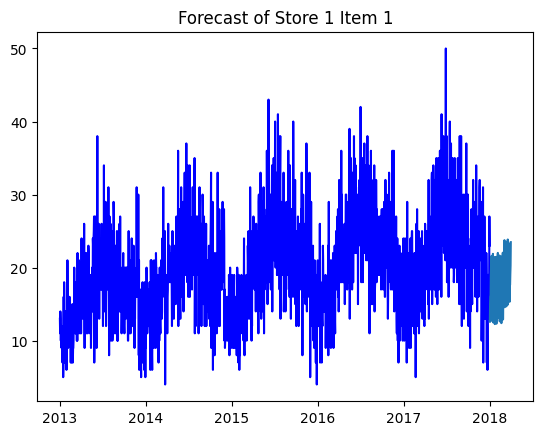

In [68]:
fig, ax = plt.subplots()
ax.plot(temp.sales, 'blue')
ax.plot(p.prediction)

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

In [69]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,51):
    for s in range(1,6):
        buf = df[(df.item==i)&(df.store==s)].copy()
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        exog_train = exog_train.astype(int)
        #fitting
        mod = SARIMAX(tra,order=(6,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        
        target_exog = target_exog.astype(int) 
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

item: 1 store: 1 Finished.
item: 1 store: 2 Finished.
item: 1 store: 3 Finished.
item: 1 store: 4 Finished.
item: 1 store: 5 Finished.
item: 2 store: 1 Finished.
item: 2 store: 2 Finished.
item: 2 store: 3 Finished.
item: 2 store: 4 Finished.
item: 2 store: 5 Finished.
item: 3 store: 1 Finished.
item: 3 store: 2 Finished.
item: 3 store: 3 Finished.
item: 3 store: 4 Finished.
item: 3 store: 5 Finished.
item: 4 store: 1 Finished.
item: 4 store: 2 Finished.
item: 4 store: 3 Finished.
item: 4 store: 4 Finished.
item: 4 store: 5 Finished.
item: 5 store: 1 Finished.
item: 5 store: 2 Finished.
item: 5 store: 3 Finished.
item: 5 store: 4 Finished.
item: 5 store: 5 Finished.
item: 6 store: 1 Finished.
item: 6 store: 2 Finished.
item: 6 store: 3 Finished.
item: 6 store: 4 Finished.
item: 6 store: 5 Finished.
item: 7 store: 1 Finished.
item: 7 store: 2 Finished.
item: 7 store: 3 Finished.
item: 7 store: 4 Finished.
item: 7 store: 5 Finished.
item: 8 store: 1 Finished.
item: 8 store: 2 Finished.
i

In [70]:
df = pd.DataFrame(results)

In [71]:
df

,0
0,12.591595
1,14.990881
2,16.049807
3,16.200970
4,18.701414
...,...
22495,67.650555
22496,69.502141
22497,70.733310
22498,73.880245


In [72]:
df2 = pd.read_csv('test.csv')
df2

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
22495,44545,2018-03-27,5,50
22496,44546,2018-03-28,5,50
22497,44547,2018-03-29,5,50
22498,44548,2018-03-30,5,50


In [102]:
df2['sales']=results

In [103]:
df2

,id,date,store,item,sales,description,size
0,0,2018-01-01,1,1,12.591595,T-Shirts,XS
1,1,2018-01-02,1,1,14.990881,T-Shirts,XS
2,2,2018-01-03,1,1,16.049807,T-Shirts,XS
3,3,2018-01-04,1,1,16.200970,T-Shirts,XS
4,4,2018-01-05,1,1,18.701414,T-Shirts,XS
...,...,...,...,...,...,...,...
22495,44545,2018-03-27,5,50,67.650555,Saree,-
22496,44546,2018-03-28,5,50,69.502141,Saree,-
22497,44547,2018-03-29,5,50,70.733310,Saree,-
22498,44548,2018-03-30,5,50,73.880245,Saree,-


In [104]:
df2.to_csv('date_sub.csv')

In [105]:
item_info={1:('T-Shirts','XS'),2:('T-Shirts','S'),3:('T-Shirts','M'),4:('T-Shirts','L'),5:('T-Shirts','XL'),6:('T-Shirts','XXL'),7:('T-Shirts','XXXL'),
           8:('Frocks','XS'),9:('Frocks','S'),10:('Frocks','M'),11:('Frocks','L'),12:('Frocks','XL'),13:('Frocks','XXL'),14:('Frocks','XXXL'),
           15:('Pants','XS'),16:('Pants','S'),17:('Pants','M'),18:('Pants','L'),19:('Pants','XL'),20:('Pants','XXL'),21:('Pants','XXXL'),
           22:('Lehenga','XS'),23:('Lehenga','S'),24:('Lehenga','M'),25:('Lehenga','L'),26:('Lehenga','XL'),27:('Lehenga','XXL'),28:('Lehenga','XXXL'),
           29:('Kurtis','XS'),30:('Kurtis','S'),31:('Kurtis','M'),32:('Kurtis','L'),33:('Kurtis','XL'),34:('Kurtis','XXL'),35:('Kurtis','XXXL'),
           36:('Leggings','XS'),37:('Leggings','S'),38:('Leggings','M'),39:('Leggings','L'),40:('Leggings','XL'),41:('Leggings','XXL'),42:('Leggings','XXXL'),
           43:('Jeans','XS'),44:('Jeans','S'),45:('Jeans','M'),46:('Jeans','L'),47:('Jeans','XL'),48:('Jeans','XXL'),49:('Jeans','XXXL'),
           50:('Saree','-')
           }

In [106]:

# Define a function to map item numbers to descriptions and sizes using the dictionary
def map_description(item):
    info = item_info.get(item, ('unknown', 'unknown'))
    return info[0]

def map_size(item):
    info = item_info.get(item, ('unknown', 'unknown'))
    return info[1]

# Apply the functions to create the 'description' and 'size' columns
df2['description'] = df2['item'].apply(map_description)
df2['size'] = df2['item'].apply(map_size)

print(df2)

          id        date  store  item      sales description size
0          0  2018-01-01      1     1  12.591595    T-Shirts   XS
1          1  2018-01-02      1     1  14.990881    T-Shirts   XS
2          2  2018-01-03      1     1  16.049807    T-Shirts   XS
3          3  2018-01-04      1     1  16.200970    T-Shirts   XS
4          4  2018-01-05      1     1  18.701414    T-Shirts   XS
...      ...         ...    ...   ...        ...         ...  ...
22495  44545  2018-03-27      5    50  67.650555       Saree    -
22496  44546  2018-03-28      5    50  69.502141       Saree    -
22497  44547  2018-03-29      5    50  70.733310       Saree    -
22498  44548  2018-03-30      5    50  73.880245       Saree    -
22499  44549  2018-03-31      5    50  78.869396       Saree    -

[22500 rows x 7 columns]


In [107]:
df2.to_csv('date_sub.csv',index=False)

In [108]:
df=pd.read_csv('monthly_sales.csv')

In [109]:
item_info={1:('T-Shirts','XS'),2:('T-Shirts','S'),3:('T-Shirts','M'),4:('T-Shirts','L'),5:('T-Shirts','XL'),6:('T-Shirts','XXL'),7:('T-Shirts','XXXL'),
           8:('Frocks','XS'),9:('Frocks','S'),10:('Frocks','M'),11:('Frocks','L'),12:('Frocks','XL'),13:('Frocks','XXL'),14:('Frocks','XXXL'),
           15:('Pants','XS'),16:('Pants','S'),17:('Pants','M'),18:('Pants','L'),19:('Pants','XL'),20:('Pants','XXL'),21:('Pants','XXXL'),
           22:('Lehenga','XS'),23:('Lehenga','S'),24:('Lehenga','M'),25:('Lehenga','L'),26:('Lehenga','XL'),27:('Lehenga','XXL'),28:('Lehenga','XXXL'),
           29:('Kurtis','XS'),30:('Kurtis','S'),31:('Kurtis','M'),32:('Kurtis','L'),33:('Kurtis','XL'),34:('Kurtis','XXL'),35:('Kurtis','XXXL'),
           36:('Leggings','XS'),37:('Leggings','S'),38:('Leggings','M'),39:('Leggings','L'),40:('Leggings','XL'),41:('Leggings','XXL'),42:('Leggings','XXXL'),
           43:('Jeans','XS'),44:('Jeans','S'),45:('Jeans','M'),46:('Jeans','L'),47:('Jeans','XL'),48:('Jeans','XXL'),49:('Jeans','XXXL'),
           50:('Saree','-')
           }

In [110]:

# Define a function to map item numbers to descriptions and sizes using the dictionary
def map_description(item):
    info = item_info.get(item, ('unknown', 'unknown'))
    return info[0]

def map_size(item):
    info = item_info.get(item, ('unknown', 'unknown'))
    return info[1]

# Apply the functions to create the 'description' and 'size' columns
df['description'] = df['item'].apply(map_description)
df['size'] = df['item'].apply(map_size)

print(df)

     Unnamed: 0  store  item year_month        sales description  size
0             0      1     1    2018-01   523.232877    T-Shirts    XS
1             1      1     1    2018-02   494.250144    T-Shirts    XS
2             2      1     1    2018-03   608.837092    T-Shirts    XS
3             3      1     2    2018-01  1237.790653    T-Shirts     S
4             4      1     2    2018-02  1438.662486    T-Shirts     S
..          ...    ...   ...        ...          ...         ...   ...
745         745      5    49    2018-02   786.156652       Jeans  XXXL
746         746      5    49    2018-03  1031.834813       Jeans  XXXL
747         747      5    50    2018-01  1512.803567       Saree     -
748         748      5    50    2018-02  1671.843641       Saree     -
749         749      5    50    2018-03  2228.467203       Saree     -

[750 rows x 7 columns]


In [111]:
df.to_csv('monthly_sales.csv',index=False)

In [112]:
df

,Unnamed: 0,store,item,year_month,sales,description,size
0,0,1,1,2018-01,523.232877,T-Shirts,XS
1,1,1,1,2018-02,494.250144,T-Shirts,XS
2,2,1,1,2018-03,608.837092,T-Shirts,XS
3,3,1,2,2018-01,1237.790653,T-Shirts,S
4,4,1,2,2018-02,1438.662486,T-Shirts,S
...,...,...,...,...,...,...,...
745,745,5,49,2018-02,786.156652,Jeans,XXXL
746,746,5,49,2018-03,1031.834813,Jeans,XXXL
747,747,5,50,2018-01,1512.803567,Saree,-
748,748,5,50,2018-02,1671.843641,Saree,-


In [113]:
import math

In [114]:
df['sales'] = df['sales'].apply(lambda x: math.ceil(x))

In [115]:
df

,Unnamed: 0,store,item,year_month,sales,description,size
0,0,1,1,2018-01,524,T-Shirts,XS
1,1,1,1,2018-02,495,T-Shirts,XS
2,2,1,1,2018-03,609,T-Shirts,XS
3,3,1,2,2018-01,1238,T-Shirts,S
4,4,1,2,2018-02,1439,T-Shirts,S
...,...,...,...,...,...,...,...
745,745,5,49,2018-02,787,Jeans,XXXL
746,746,5,49,2018-03,1032,Jeans,XXXL
747,747,5,50,2018-01,1513,Saree,-
748,748,5,50,2018-02,1672,Saree,-


In [116]:
df.to_csv('monthly_sales_final.csv')

In [117]:
df

,Unnamed: 0,store,item,year_month,sales,description,size
0,0,1,1,2018-01,524,T-Shirts,XS
1,1,1,1,2018-02,495,T-Shirts,XS
2,2,1,1,2018-03,609,T-Shirts,XS
3,3,1,2,2018-01,1238,T-Shirts,S
4,4,1,2,2018-02,1439,T-Shirts,S
...,...,...,...,...,...,...,...
745,745,5,49,2018-02,787,Jeans,XXXL
746,746,5,49,2018-03,1032,Jeans,XXXL
747,747,5,50,2018-01,1513,Saree,-
748,748,5,50,2018-02,1672,Saree,-


In [96]:
df3 = pd.read_csv('date_sub.csv')
df3['date'] = pd.to_datetime(df3['date'])
df3['year_month'] = df3['date'].dt.to_period('M')
store_item_monthly_sales = df3.groupby(['store', 'item', 'year_month'], as_index=False)['sales'].sum()

df3 = pd.DataFrame(store_item_monthly_sales)
df3.to_csv('monthly_sales.csv')

In [97]:
df3

,store,item,year_month,sales
0,1,1,2018-01,523.232877
1,1,1,2018-02,494.250144
2,1,1,2018-03,608.837092
3,1,2,2018-01,1237.790653
4,1,2,2018-02,1438.662486
...,...,...,...,...
745,5,49,2018-02,786.156652
746,5,49,2018-03,1031.834813
747,5,50,2018-01,1512.803567
748,5,50,2018-02,1671.843641


In [ ]:
df=pd.read_csv('montly_sales.csv')

In [89]:
import math

In [90]:
df3['sales'] = df3['sales'].apply(lambda x: math.ceil(x))

In [87]:
df3

,store,item,year_month,sales
0,1,1,2018-01,523
1,1,1,2018-02,494
2,1,1,2018-03,608
3,1,2,2018-01,1237
4,1,2,2018-02,1438
...,...,...,...,...
745,5,49,2018-02,786
746,5,49,2018-03,1031
747,5,50,2018-01,1512
748,5,50,2018-02,1671


In [91]:
df3.to_csv('final.csv',index=True)

In [92]:
df3

,store,item,year_month,sales
0,1,1,2018-01,523
1,1,1,2018-02,494
2,1,1,2018-03,608
3,1,2,2018-01,1237
4,1,2,2018-02,1438
...,...,...,...,...
745,5,49,2018-02,786
746,5,49,2018-03,1031
747,5,50,2018-01,1512
748,5,50,2018-02,1671
